# Exploring Sog1 data

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../data/sog1/all_shuffle_vars_JD.csv", index_col=0)
df.head()


pos_vals = pd.Series(
    np.vstack(df["Description_var"].str.split("pos").values)[:, 1]
    ).str.split("_", expand=True).astype(int)
pos_vals[0] *= 2
df.loc[:, ['shuffle_start', 'shuffle_idx']] = pos_vals.values
# Extract state sizes
shuffle_size = df["Description_var"].str.extract("(?<=_shuffle_size)(\d+)(?=_)").values.flatten().astype(int)
df["shuffle_size"] = shuffle_size
df['shuffle_size'].value_counts()

shuffle_size
4     933
6     900
8     850
10    800
2      90
Name: count, dtype: int64

In [56]:
df['tile_wt'].unique()
df.head()

,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,shuffle_idx,shuffle_size
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,0,1,2
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,2,1,2
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,4,1,2
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,8,1,2
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,10,1,2


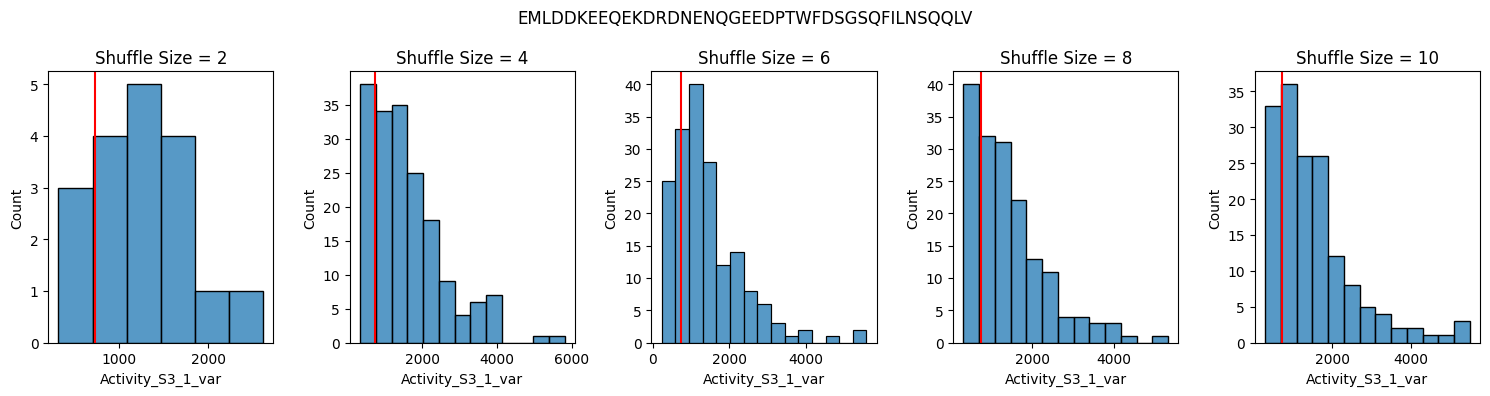

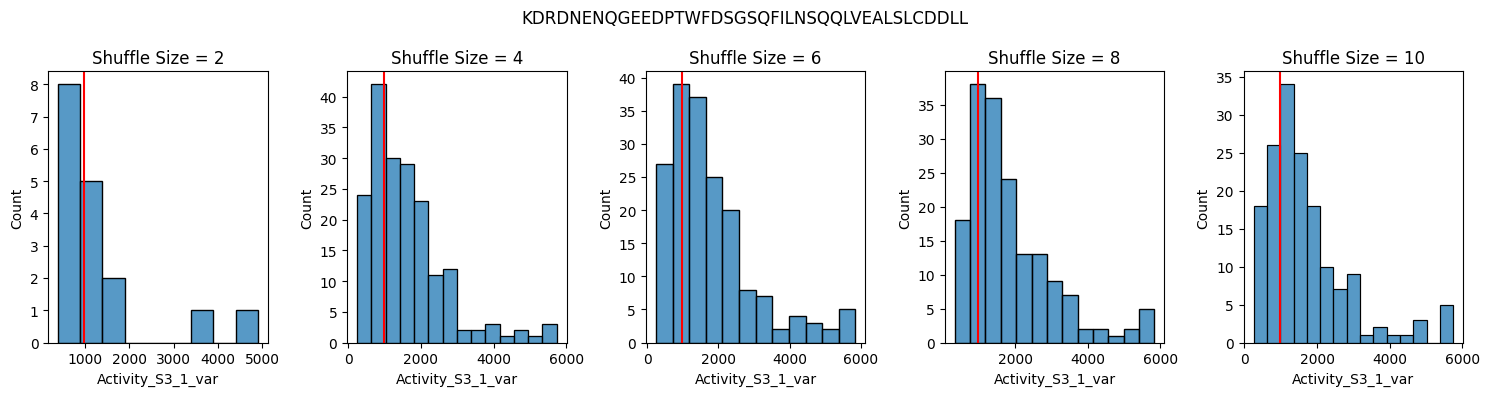

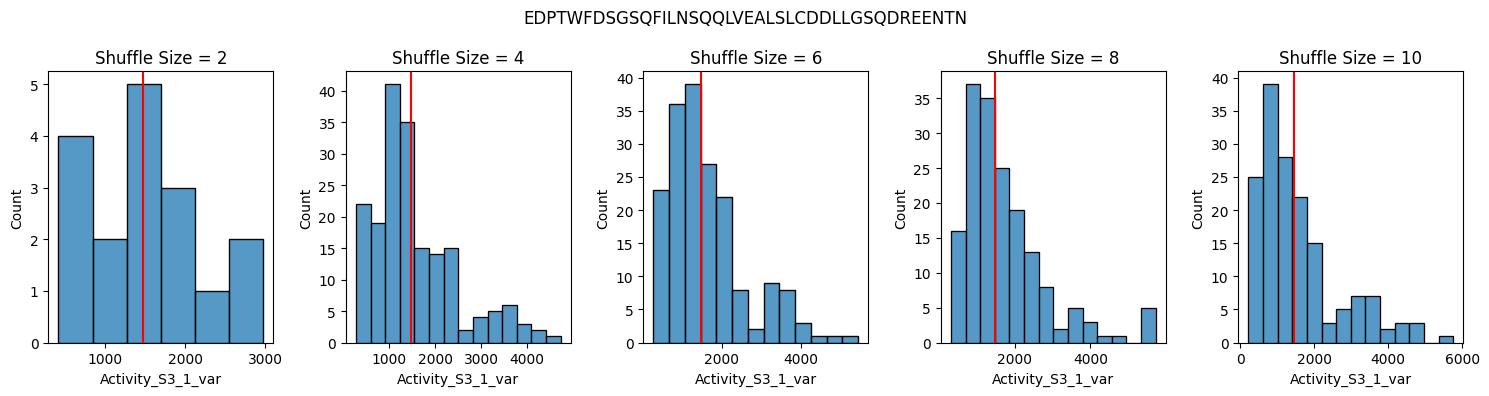

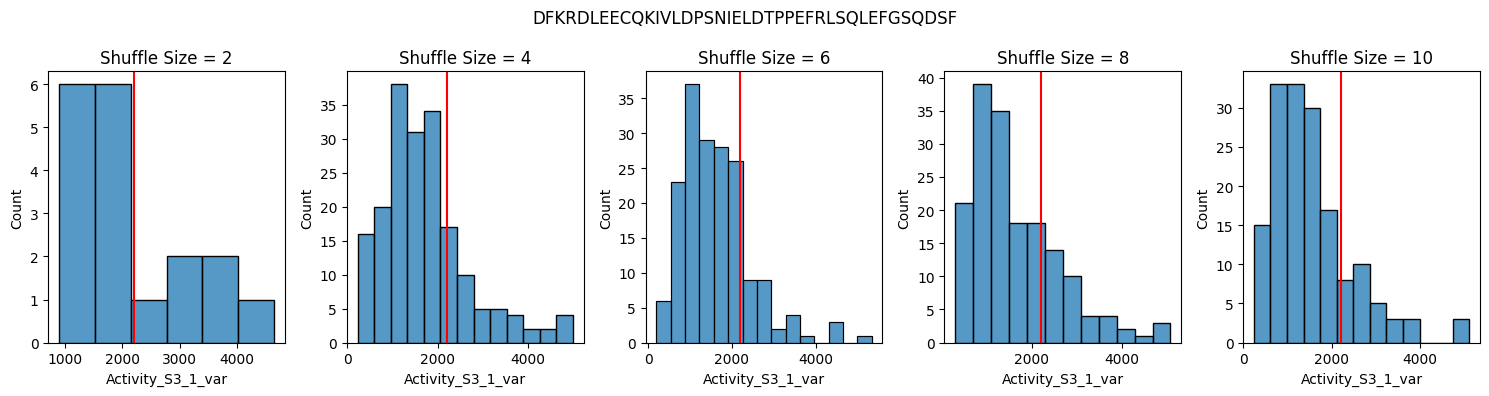

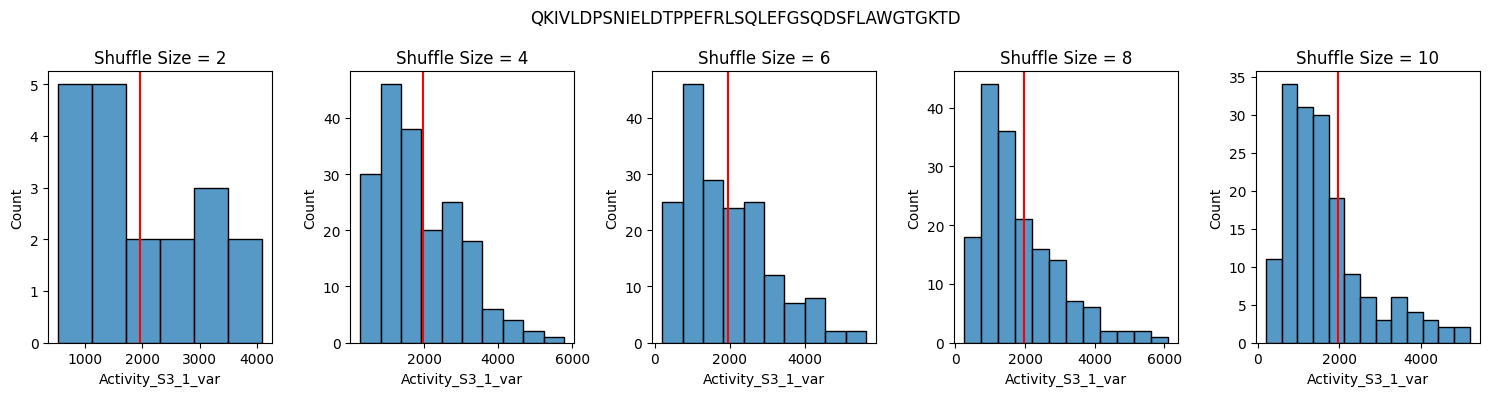

In [75]:
ss = 4 
seq = "EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV"

for seq in df["tile_wt"].unique():
    df_i = df.loc[(df["tile_wt"]==seq)]
    sss = df_i["shuffle_size"].unique()
    fig, axs = plt.subplots(1, len(sss), figsize=(3*len(sss), 4))
    for i, ss in enumerate(sss):
        df_ij = df_i.loc[(df_i["shuffle_size"] == ss)]
        sns.histplot(df_ij, x="Activity_S3_1_var", ax=axs[i])
        axs[i].axvline(df_ij["Activity_S3_1_wt"].unique().item(),
                    c='r',)
        axs[i].set_title(f"Shuffle Size = {ss}")
    plt.suptitle(seq)
    plt.tight_layout()
    plt.show()

In [45]:
import torch
from actpred.models import ActCNNSystem
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))
model.eval()

df["pred"] = df["tile_var"].apply(lambda x: model(x).item())

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


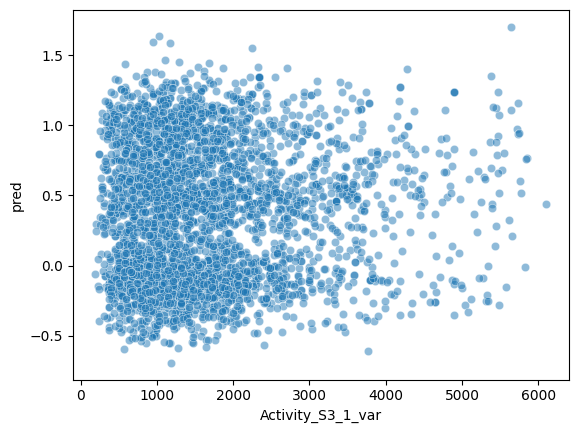

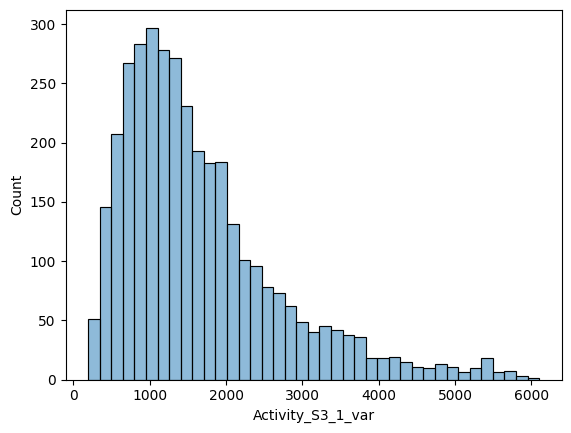

In [54]:
sns.scatterplot(df, x="Activity_S3_1_var", y="pred", alpha=0.5)
plt.show()

sns.histplot(df, x="Activity_S3_1_var", alpha=.5)
plt.show()

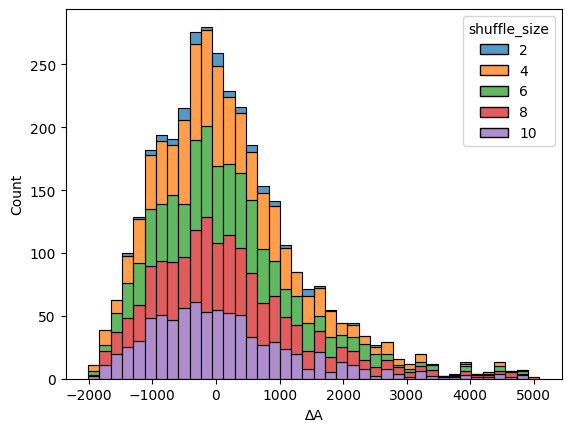

In [86]:
df["delta_a"] = df["Activity_S3_1_var"] - df["Activity_S3_1_wt"]
sns.histplot(df, x="delta_a", hue="shuffle_size", multiple="stack", palette="tab10")
plt.xlabel("∆A")
plt.show()

# df

Let's look at correlation between shuffled segment similarity to original segment and ∆A

$$s = \frac{1}{shuffle size}\sum_i{1\{shuffled_i = original_i\}}$$

In [96]:
display(df.head(2))

df["tile_var"].str[1:5]
fn_shuffle = lambda row: row["tile_var"][row["shuffle_start"]:row["shuffle_start"]+row["shuffle_size"]]
fn_orig = lambda row: row["tile_wt"][row["shuffle_start"]:row["shuffle_start"]+row["shuffle_size"]]

df["shuffle_seq"] = df.apply(fn_shuffle, axis=1)
df["shuffle_seq_wt"] = df.apply(fn_orig, axis=1)
df

,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,shuffle_idx,shuffle_size,delta_a
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,0,1,2,28.675146
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,2,1,2,738.590597


,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,shuffle_idx,shuffle_size,delta_a,shuffle_seq,shuffle_seq_wt
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,0,1,2,28.675146,ME,EM
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,2,1,2,738.590597,DL,LD
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,4,1,2,971.892240,KD,DK
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,8,1,2,-409.735418,EQ,QE
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,10,1,2,-57.500934,DK,KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,410,449,42_shuffle_size10_ss2_pos15_6,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSLWTGADFGTK,908.291934,601.458747,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,6,10,-1054.489587,LWTGADFGTK,FLAWGTGKTD
3569,410,449,42_shuffle_size10_ss2_pos15_7,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTTKGDALWFG,3620.400685,3866.897601,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,7,10,1657.619164,TTKGDALWFG,FLAWGTGKTD
3570,410,449,42_shuffle_size10_ss2_pos15_8,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTLDFGKGATW,1014.433117,629.787497,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,8,10,-948.348405,TLDFGKGATW,FLAWGTGKTD
3571,410,449,42_shuffle_size10_ss2_pos15_9,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTWFTGGADLK,2375.766170,1866.065374,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,9,10,412.984649,TWFTGGADLK,FLAWGTGKTD


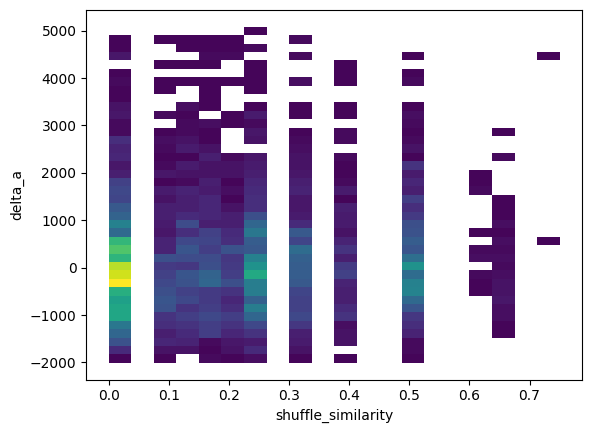

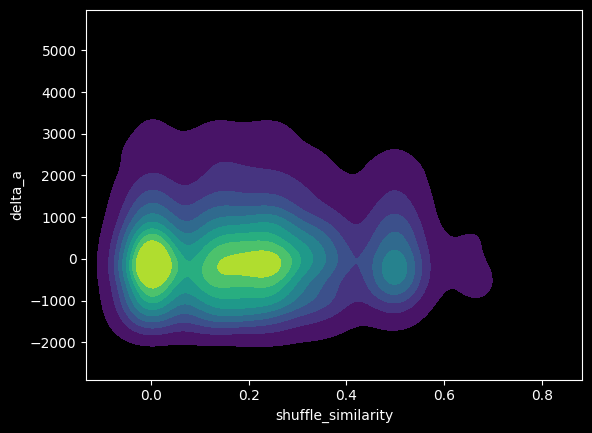

In [131]:
from collections import Counter
from math import factorial

perm = lambda seq: factorial(len(seq)) // np.prod([factorial(i) for i in Counter(seq).values()])
df["shuffle_seq"].apply(perm).value_counts()
# alphabet="ACDEFGHIKLMNPQRSTVWY"
# perm(alphabet[:10])

def similarity(s1, s2):
    assert len(s1) == len(s2)
    return sum([s1[i] == s2[i] for i in range(len(s1))]) / len(s1)

sims = [similarity(s1, s2) for (s1, s2) in df[["shuffle_seq", "shuffle_seq_wt"]].values]
df["shuffle_similarity"] = sims

sns.histplot(df, x="shuffle_similarity", y="delta_a", cmap="viridis")
plt.show()
with plt.style.context("dark_background"):
    sns.kdeplot(df, x="shuffle_similarity", y="delta_a", cmap="viridis", fill=True,)
    plt.show()

In [ ]:
import re
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

count_kmers = lambda seq, pair: seq.count(pair)
get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
X_aa = np.vstack(df["Seq"].apply(get_input_single).values)
X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split(X_aa, y_cont, stratify=y_bin, train_size=.8)

regr_single = LinearRegression()
regr_single.fit(X_aa_train, y_aa_train)
print(regr_single.score(X_aa_test, y_aa_test)) 